In [1]:
import torch
import torch.nn.functional as F
import sympy as sp
import pandas as pd
import numpy as np
import numdifftools as nd

In [2]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv('physics_equations.csv')

functions = []
num_vars_per_func = []

for _, row in df.iterrows():
    formula = row['Formula']
    num_vars = row['# variables']
    function_details = {
        'formula': formula,
        'variables': []
    }
    
    for i in range(1, 11):  
        v_name = row.get(f'v{i}_name', None)
        v_low = row.get(f'v{i}_low', None)
        v_high = row.get(f'v{i}_high', None)
        
        if pd.notna(v_name):
            function_details['variables'].append({
                'name': v_name,
                'low': v_low,
                'high': v_high
            })
    
    functions.append(function_details)
    num_vars_per_func.append(num_vars)

'''for i, func in enumerate(functions):
    print(f"Function {i+1}:")
    print(f"  Formula: {func['formula']}")
    print(f"  Number of Variables: {num_vars_per_func[i]}")
    print("  Variables:")
    for var in func['variables']:
        print(f"    - Name: {var['name']}, Range: ({var['low']}, {var['high']})")
    print()'''

'for i, func in enumerate(functions):\n    print(f"Function {i+1}:")\n    print(f"  Formula: {func[\'formula\']}")\n    print(f"  Number of Variables: {num_vars_per_func[i]}")\n    print("  Variables:")\n    for var in func[\'variables\']:\n        print(f"    - Name: {var[\'name\']}, Range: ({var[\'low\']}, {var[\'high\']})")\n    print()'

In [4]:
def generate_function(function, sample_size, x, max_vars, device):
    sympy_symbols = []
    param_tensors = []
    
    for var in function["variables"]:
        sym = sp.symbols(var["name"])
        sympy_symbols.append(sym)
        min_val, max_val = var["low"], var["high"]
        param = (max_val - min_val) * torch.rand(sample_size, 1, device=device) + min_val
        param_tensors.append(param)
    sympy_symbols.append(sp.symbols('x'))
    params = torch.cat(param_tensors, dim=1)
    padded_params = F.pad(params, pad=(0, max_vars - params.size(1)))
    padded_params = padded_params.expand(sample_size, max_vars)
    formula = sp.sympify(function["formula"])
    eval_func = sp.lambdify(sympy_symbols, formula, modules="numpy")
        
    results = []
    for xi in x:
        input_values = torch.cat([params, xi.expand(sample_size, 1)], dim=1)
        results.append(eval_func(*input_values.T))
    results = torch.stack(results, dim=1)
    
    return [results, formula, sympy_symbols, padded_params]

In [5]:
sample_size = 10000
sequence_length = 100
num_funcs = 10
max_vars = 5

x_values = torch.linspace(-1, 1, sequence_length).to(device)
hold = []
for f in range(num_funcs): #functions[0:10]:
    try:
        results = generate_function(functions[f], sample_size, x_values, max_vars, device)
        results.append(f)
        hold.append(results)
    except Exception as e:
        print(f"Error processing function {f}: {e}")

In [6]:
y_values = torch.stack([l[0] for l in hold])
formulas = [l[1] for l in hold]
symbols = [l[2] for l in hold]
param_values = [l[3] for l in hold]
num_params = torch.tensor([len(l[2])-1 for l in hold])
function_labels = [l[4] for l in hold]

In [7]:
full_params = torch.zeros(num_funcs, sample_size, num_funcs*max_vars)
for f in range(num_funcs):
    for i in range(sample_size):
        full_params[f, i, f*max_vars:f*max_vars+max_vars] = param_values[f][i]
full_params.shape

torch.Size([10, 10000, 50])

In [8]:
param_values = torch.stack(param_values)
full_params = full_params.flatten(0, 1)

In [9]:
function_labels = torch.tensor(function_labels).repeat_interleave(sample_size)

In [10]:
def evaluate_function(params, symbols, formula, x):
    var_values = {symbols[j]: params[:, j] for j in range(len(symbols)-1)}
    eval_func = sp.lambdify(symbols, formula, modules="numpy")
    results = []
    for xi in x:
        var_values[symbols[-1]] = xi
        np_values = {str(sym): var_values[sym].detach().cpu().numpy() for sym in symbols}
        results.append(eval_func(**np_values))
    tensor_results = [torch.tensor(r, device=device) for r in results]
    return torch.stack(tensor_results, dim=1)

In [11]:
epsilon = 1e-4
derivatives = torch.zeros(num_funcs, sample_size, sequence_length, max_vars)
for f in range(num_funcs):
    params_n = param_values[f].clone().detach().requires_grad_(True)
    for p in range(len(symbols[f])-1):
        plus = params_n.clone()
        minus = params_n.clone()
        plus[:,p] += epsilon
        forward_values = evaluate_function(plus, symbols[f], formulas[f], x_values)
        minus[:, p] -= epsilon
        backward_values = evaluate_function(minus, symbols[f], formulas[f], x_values)
        derivatives[f, :, :, p] = (forward_values - backward_values) / (2 * epsilon)
derivatives.shape

torch.Size([10, 10000, 100, 5])

In [12]:
hessians = torch.zeros(num_funcs, sample_size, sequence_length, max_vars, max_vars)
for f in range(num_funcs):
    params_f = param_values[f].clone().detach().requires_grad_(True)
    for j in range(len(symbols[f])-1):
        for k in range(len(symbols[f])-1):
            plus_plus = params_f.clone()
            plus_minus = params_f.clone()
            minus_plus = params_f.clone()
            minus_minus = params_f.clone()

            plus_plus[:, j] += epsilon
            plus_plus[:, k] += epsilon

            plus_minus[:, j] += epsilon
            plus_minus[:, k] -= epsilon

            minus_plus[:, j] -= epsilon
            minus_plus[:, k] += epsilon

            minus_minus[:, j] -= epsilon
            minus_minus[:, k] -= epsilon

            forward_forward = evaluate_function(plus_plus, symbols[f], formulas[f], x_values)
            forward_backward = evaluate_function(plus_minus, symbols[f], formulas[f], x_values)
            backward_forward = evaluate_function(minus_plus, symbols[f], formulas[f], x_values)
            backward_backward = evaluate_function(minus_minus, symbols[f], formulas[f], x_values)
            hessians[f, :, :, j, k] = (forward_forward - forward_backward - backward_forward + backward_backward) / (4 * epsilon **2)
hessians.shape

torch.Size([10, 10000, 100, 5, 5])

In [13]:
y_values = y_values.flatten(0, 1)
derivatives = derivatives.flatten(0, 1)
hessians = hessians.flatten(0, 1)
hessians = hessians.flatten(2,3)
param_values = param_values.flatten(0, 1)

In [14]:
print(f"x_values: {x_values.shape}")
print(f"y_values: {y_values.shape}")
print(f"derivatives: {derivatives.shape}")
print(f"hessians: {hessians.shape}")
print(f"param_values: {param_values.shape}")
print(f"formulas: {len(formulas)}")
print(f"symbols: {len(symbols)}")
print(f"num_params: {num_params.shape}")
print(f"functions: {len(function_labels)}")
print(f"full_params: {full_params.shape}")

x_values: torch.Size([100])
y_values: torch.Size([100000, 100])
derivatives: torch.Size([100000, 100, 5])
hessians: torch.Size([100000, 100, 25])
param_values: torch.Size([100000, 5])
formulas: 10
symbols: 10
num_params: torch.Size([10])
functions: 100000
full_params: torch.Size([100000, 50])


tensor(0)
a*x**2 + b*x + c


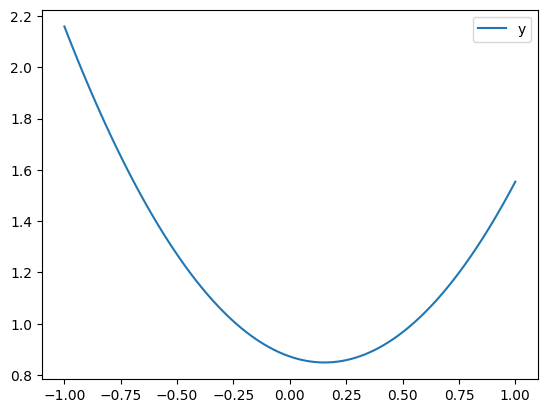

In [15]:
import matplotlib.pyplot as plt

r = np.random.randint(sample_size*num_funcs)
plt.plot(x_values.cpu().numpy(), y_values[r].cpu().numpy(), label='y')
#plt.plot(x_values.cpu().numpy(), derivatives[r, :, 0].cpu().numpy(), label='d')
plt.legend()
print(function_labels[r])
print(formulas[function_labels[r]])

In [16]:
torch.save({
    'x_values': x_values,
    'y_values': y_values,
}, 'hold_data1.pth')

torch.save({
    'function_labels': function_labels,
    'formulas': formulas,
    'symbols': symbols,
}, 'hold_data2.pth')

torch.save({
    'num_params': num_params,
    'param_values': param_values,
    'full_params': full_params,
}, 'hold_data3.pth')

In [17]:
torch.save({
    'derivatives1': derivatives[0:derivatives.size(0)//2]
}, 'hold_data4.pth')
torch.save({
    'derivatives2': derivatives[derivatives.size(0):derivatives.size(0)]
}, 'hold_data5.pth')